# [Link to my Youtube Video Explaining this whole Notebook](https://www.youtube.com/watch?v=ciuLu99UiJM&list=PLxqBkZuBynVRyOJs4RWmB_fKlOVe5S8CR&index=29)

[![Imgur](https://imgur.com/qmsX0qI.png)](https://www.youtube.com/watch?v=ciuLu99UiJM&list=PLxqBkZuBynVRyOJs4RWmB_fKlOVe5S8CR&index=29)

In [1]:
from pathlib import Path
import random
from PIL import Image as Img
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import color
from glob import glob

In [2]:
# directory path for local machine
ROOT_DIR = Path("../../input/uw-madison-gi-tract-image-segmentation/")
train_root_dir = ROOT_DIR / 'train'

df_train = pd.read_csv(ROOT_DIR / 'train.csv')
df_train.sample(3)

,id,class,segmentation
19299,case142_day0_slice_0018,large_bowel,NaN
7069,case139_day16_slice_0053,small_bowel,NaN
49348,case147_day0_slice_0066,small_bowel,NaN


In [3]:
list_images = map(str, train_root_dir.rglob('*/*/*/*'))
list_images

In [5]:
img_attr = pd.DataFrame([(c, c.split('/')[-3], c.split('/')[-1]) for c in list_images], columns = ['full_path', 'case_and_day', 'img_file_name'])

img_attr.head()

,full_path,case_and_day,img_file_name
0,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0085_266_266_1.50_1.50.png
1,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0082_266_266_1.50_1.50.png
2,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0003_266_266_1.50_1.50.png
3,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0034_266_266_1.50_1.50.png
4,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0088_266_266_1.50_1.50.png


In [6]:
img_attr.head()

,full_path,case_and_day,img_file_name
0,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0085_266_266_1.50_1.50.png
1,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0082_266_266_1.50_1.50.png
2,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0003_266_266_1.50_1.50.png
3,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0034_266_266_1.50_1.50.png
4,../../input/uw-madison-gi-tract-image-segmenta...,case44_day0,slice_0088_266_266_1.50_1.50.png


In [7]:
img_attr['slice'] = img_attr['img_file_name'].apply(lambda x: f"slice_{x.split('_')[1]}")

img_attr['height'] = img_attr['img_file_name'].apply(lambda x: int(x.split('_')[2]))

img_attr['width']  = img_attr['img_file_name'].apply(lambda x: int(x.split('_')[3]))

img_attr['id']     = img_attr['case_and_day'] + '_' + img_attr['slice']

In [8]:
df_train = pd.merge(df_train, img_attr, on='id', how='left')
df_train.sample(3)

,id,class,segmentation,full_path,case_and_day,img_file_name,slice,height,width
63070,case11_day13_slice_0032,small_bowel,NaN,../../input/uw-madison-gi-tract-image-segmenta...,case11_day13,slice_0032_360_310_1.50_1.50.png,slice_0032,360,310
94152,case146_day0_slice_0089,large_bowel,13981 9 14246 14 14511 20 14777 24 15043 26 15...,../../input/uw-madison-gi-tract-image-segmenta...,case146_day0,slice_0089_266_266_1.50_1.50.png,slice_0089,266,266
44351,case67_day12_slice_0128,stomach,NaN,../../input/uw-madison-gi-tract-image-segmenta...,case67_day12,slice_0128_266_266_1.50_1.50.png,slice_0128,266,266


# Plot Random Images

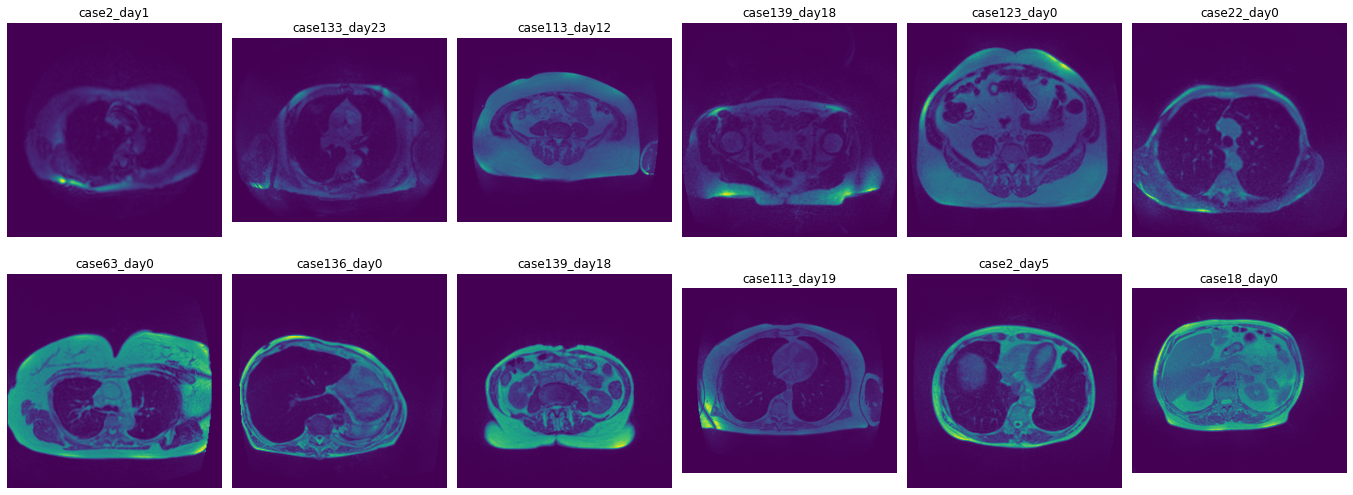

In [9]:
list_images = list(train_root_dir.rglob('*/*/*/*'))

num_columns, num_rows = 6, 2

fig, axes =  plt.subplots(num_rows, num_columns, figsize = (24, 9))

images = random.choices(list_images, k = num_columns * num_rows )

for num, img in enumerate(images):
    i = num % num_columns
    j = num // num_columns
    image = Img.open(img)
    image = np.array(image)
    axes[j, i].axis('off')
    axes[j, i].set_title(str(img.parent).strip('/scans').split('/')[-1], color='black')
    axes[j, i].imshow(image / image.max())

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
    

In [10]:
def rle_decode(rle, height, width , fill=255):
    """
    Decodes a run-length encoded (RLE) string into a binary mask.

    Args:
        rle (str): Run-length encoded string.
        height (int): Height of the output mask.
        width (int): Width of the output mask.
        fill (int, optional): Value to fill the mask with. Defaults to 255.

    Returns:
        numpy.ndarray: Decoded binary mask.

    """
    s = rle.split()
    # print('s after split ', s)
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ''' First I need the s[0:] because to get all the 'start' positions,
    I need to begin from 0-indexed element and then jump every every other step
    
    And then to get the run-length, I need begin from 1-indexed element and jump every other element    
    '''
    # print("start, length ", start, length)
    start -= 1
    # print('start after -= 1 ', start)
    mask = np.zeros(height*width, dtype=np.uint8)
    # print('zip(start, length) ', zip(start, length))
    for position, run_length in zip(start, length):
        # print('position after zipping ', position)
        # print('run_length after zipping ', run_length)
        # 0 represents black and 255 represents white.
        mask[position:position+run_length] = fill
    # print('mask.shape before T ', mask.shape) # (65025,) which is actually 255*255
    mask = mask.reshape(width,height).T
    # print('mask.shape AFTER T ', mask.shape) # (255, 255)
    mask = np.ascontiguousarray(mask)
    return mask

In [11]:
# x = np.random.randint(1, 3, (1, 3))
# x

# x =  '1 3 10 5'
# x =  '28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10'

# y = rle_decode(x, 255, 255)
# # y.shape
# y

/tmp/ipykernel_116139/518945041.py:26: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  result_image = color.label2rgb(mask, np.array(image) / np.array(image).max())


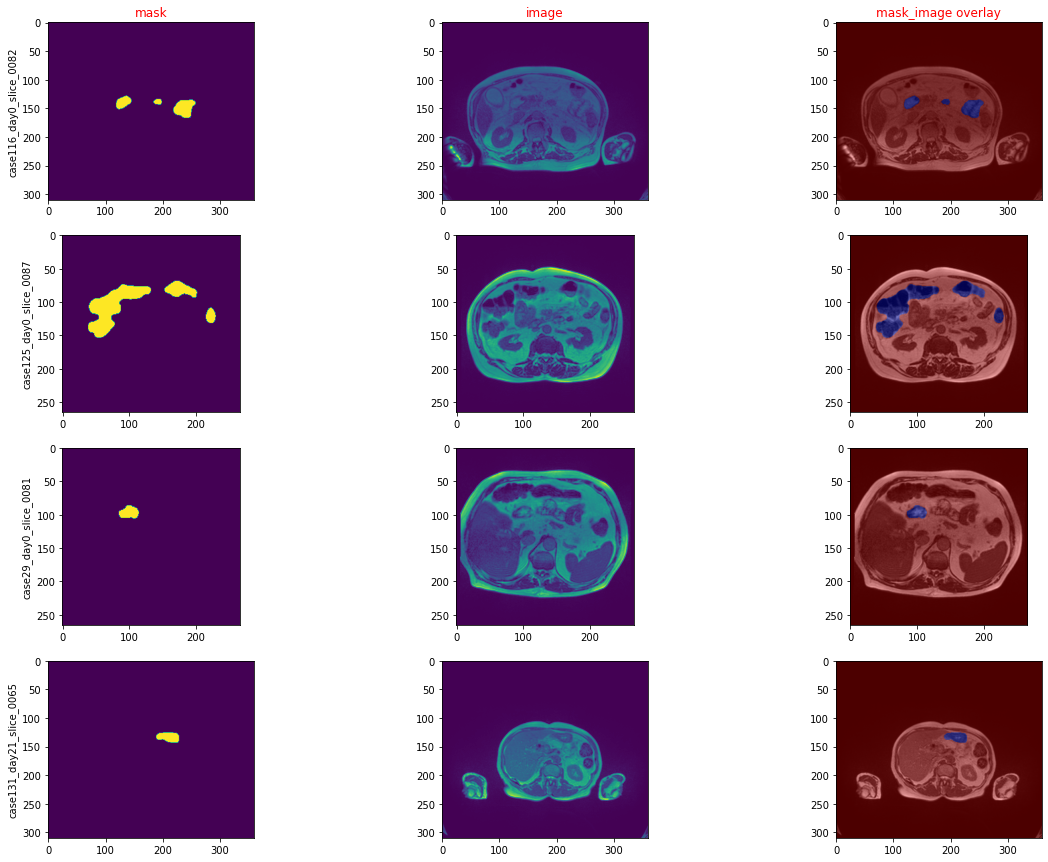

In [14]:
X = df_train[df_train['segmentation'].notnull()]

num_columns, num_rows = 3, 4
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 15))


for i in range(num_rows):
    # print('i is ', i)    

    sample = X.iloc[random.randint(0, X.shape[0])]

    height, width = 255, 255    
    mask = rle_decode(sample['segmentation'], sample['height'], sample['width'], 255)
    mask = (mask / 255).astype(int).T

    # in below only for the first column I need to set the ylabel
    # for the other 2 columns I only need to 
    if i == 0 : axes[i, 0].set_title("mask", color='red')
    axes[i, 0].set_ylabel(sample['id']) # the ylabel is coming from the 'id' field
    axes[i, 0].imshow(mask)

    image = Img.open(sample['full_path'])
    if i == 0 : axes[i, 1].set_title("image", color='red')
    axes[i, 1].imshow(np.array(image))

    result_image = color.label2rgb(mask, np.array(image) / np.array(image).max())
    if i == 0 : axes[i, 2].set_title("mask_image overlay", color='red')
    axes[i, 2].imshow(result_image)

